# PyTorch Digit Classification (MNIST) & Error Analysis
**Author:** Harshad Dahake

**Context:** Supervised Learning Coursework

### Description
A PyTorch implementation of multi-class digit classification on the **MNIST** dataset, focusing on model evaluation and error diagnostics.

**Key Components:**
* **PyTorch Pipeline:** Custom `Dataset` handling for MNIST, training loop with `autograd`, and optimization.
* **Diagnostic Visualization:** Confusion Matrix generation and per-class Error Rate analysis to identify digit confusion pairs (e.g., 4 vs 9).
* **Cross-Validation:** Robust performance estimation using K-Fold validation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random

In [2]:
## LOAD DATA

In [3]:
## Load data
with open("zipcombo.dat", "r") as f:
    all_data = pd.read_csv(f, sep=r"\s+", header=None)

y_all = torch.tensor(all_data.iloc[:,0].values)
X_all = torch.tensor(all_data.iloc[:,1:].values)

D = int(np.sqrt(X_all.shape[1]))

In [4]:
### FUNCTIONS TO BE USED ACROSS OvR/OvO or Kernel Type or Experiment Orchestrators

# Data splitter: 80-20 train-test randomised split
# Test data Prediction function
# Test dat aEvaluation functions: 1) Error rates, 2) Confusion Matrix

In [5]:
## SPLIT DATA 80-20 TRAIN-TEST
def data_splitter(X, y):
    N = X.shape[0]
    train_len = int(0.8*N)
    test_len = N - train_len
    
    # randomised indices for splitting 80:20
    indices = torch.randperm(N)

    # Get train and test data indices
    train_indices = indices[:train_len]
    test_indices = indices[train_len:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, y_train, X_test, y_test

In [6]:
## PREDICTION EVAL FUNCTIONS: 1) Error Rates, 2) Confusion Matrix

In [7]:
## EVALUATE PREDICTIONS (OvR/OvO)
def evaluate_preds(preds, y_test):
    error_rate = (preds != y_test).float().mean()
    error_pct = torch.round(100*error_rate, decimals=2).item()

    return error_pct

In [8]:
## DEFINE: Confusion Matrix function: confusion_matrix(...)

## CALCULATE CONFUSION MATRIX
def confusion_matrix(preds, y_test):
    conf_mat = torch.zeros((10,10))

    for y in range(0,10):
        for p in range(0,10):
            if y == p:
                continue
            else:
                y_mask = (y_test == y).float()
                p_mask = (preds == p).float()
                
                num_y_p = (y_mask @ p_mask).sum()
                num_y = y_mask.sum()
                
                conf_mat[y,p] = torch.round(torch.divide(num_y_p,num_y)*100.00, decimals=4).item()
    
    return conf_mat

In [9]:
# Q2: OvR, Perceptron, Kernel

In [10]:
## CALCULATES GRAM MATRIX BASED ON SELECTED KERNEL TYPE/FUNCTION AND PARAMETERS FOR INPUT DATA X1, X2
def kernel_gram_matrix(X1, kernel_type: str, kernel_param: float, X2=None):
    
    if X2 is None:
        X2 = X1 # TRAINING CASE (SYMMETRIC GRAM MATRIX) || OTHERWISE, TESTING CASE
    
    if kernel_type == "polynomial":
        d = int(kernel_param)
        gram_matrix = (X1 @ X2.T).pow(d)
        return gram_matrix
    elif kernel_type == "gaussian":
        c = kernel_param
        dist_matrix = torch.cdist(X1, X2, p=2) # norm distances
        sq_dist_matrix = dist_matrix.pow(2)
        gram_matrix = torch.exp(-c * sq_dist_matrix)
        return gram_matrix
    else:
        print(f"This kernel type is NOT supported!")
        return None

In [11]:
## TRAIN FUNCTION FOR BINARY-CLASSIFICATION PERCEPTRON (OUTPUTS FINAL #MISTAKES ONLY)
def train_perceptron_2class(train_gram, y_train, max_epochs: int):
    '''
    INPUTS
        1. X_train: training data {NxD^2 tensor with N images/data points and DxD columns, where D = height/width of images, all floats}
        2. y_train: labels {-1,1}
        3. kernel_type: "polynomial" or "gaussian" kernel function
        4. kernel_param: value for 'd' param. for poly. kernel OR 'c' param. for gaussian kernel

    OUTPUTS
        1. alpha: final weight vector for trained perceptron
        2. mistakes: mistake by epoch (helps plot mistakes trend for max_epoch selection and training error monitoring)
    '''
    
    N = train_gram.shape[0]

    alpha = torch.zeros(N)
    mistakes = torch.zeros(max_epochs)
    for epoch in range(max_epochs):
        for idx in range(N):
            y = y_train[idx]
            kernel_vals = train_gram[idx]
            y_hat = 1.0 if torch.dot(alpha, kernel_vals) > 0.0 else -1.0
            if y_hat != y:
                mistakes[epoch] += 1.0
                alpha[idx] = alpha[idx] + y
        
        # print(f"Epoch {epoch+1} has {mistakes[epoch]/N*100.0:.2f}% mistakes")

        # Full training: stop only when all data points are correctly classified
        if mistakes[epoch] == 0.0:
            # print(f"No mistakes in epoch {epoch+1}! Terminating training")
            break
        # Early stopping: stop earlier than full training if max_epochs are already run || Max epoch to be set by analysing convergence trends for various kernel hyperparameter values across runs
    
    # print(f"Terminated training after epoch {epoch+1} with mistakes: {mistakes[epoch]/N*100:.2f}%")
    
    return alpha, torch.round(mistakes[epoch]/N*100, decimals=2)


In [12]:
## OvR (One Versus Rest) - Training and Prediction

In [13]:
## TRAIN CLASSIFIER(s) FOR OvR: k classifiers
def ovr_train(train_gram, y_train, max_epochs: int):
    '''
    OUTPUT
    1. alphas: Tensor (k,N) with alpha weights for N training points for k classes (OvR)
    '''
    k = 10 # all_k.shape[0] results in potentially < 10 records if a dataset doesn't have a specific digit, leading to downstream code break. Standardising to 10
    N = train_gram.shape[0]
    
    alphas = torch.zeros((k,N))
    
    for class_k in range(k):
        y_binary = torch.where(y_train == float(class_k), 1.0, -1.0) # re-label y data [if y = class_k, label = +1 else -1] => binary classification problem
        alphas[class_k], _ = train_perceptron_2class(train_gram, y_binary, max_epochs) # error_rates[class_k]
    
    return alphas # , torch.mean(error_rates).item()

In [14]:
## PREDICT CLASS FOR TEST DATA FOR OvR
def ovr_predict(test_gram, alphas):
    '''
    INPUTS:
    1. test_gram: (N_test,N_train) tensor; gram matrix K(x_test, x_train)
    2. alphas: (k,N_train) tensor with N_train alpha(weights) each for k classifiers

    OUTPUT:
    1. pred_test: (N_test) tensor; class predictions for N_test data points
    '''
    
    # (N_test,k) tensor: for each test data point, what are the k activations computer (each classifier gives a 'score' for binary classification)
    test_activations = test_gram @ alphas.T

    # Find digit (index) with maximum activation (most probable) for each of the N_test data points
    pred_test = torch.argmax(test_activations, dim=1).float()

    return pred_test

In [15]:
## Q8: IMPLEMENT OVO (One Versus One) - Training and Prediction
# Function Definitions

In [16]:
## TRAIN CLASSIFIER(s) FOR OvO: k*(k-1)/2 classifiers
def ovo_train(train_gram, y_train, max_epochs: int):
    '''
    OUTPUT
    1. alphas: Tensor (k*(k-1)/2,N) with alpha weights for N training points for k*(k-1)/2 class-pairs (OvO)
    '''
    k = 10 # all_pairs.shape[0] results in potentially < 10 records if a dataset doesn't have a specific digit, leading to downstream code break. Standardising to 10
    N = train_gram.shape[0]

    total_classifiers = k*(k-1)/2
    alphas_with_masks = dict()
    
    for class_i in range(k):
        for class_j in range((class_i+1),k):
            mask = (y_train == float(class_i)) | (y_train == float(class_j))
            train_gram_ij = train_gram[mask][:,mask]
            y_train_ij = y_train[mask]
            
            # re-label y data [if y = class_k, label = +1 else -1] => binary classification problem
            y_binary = torch.where(y_train_ij == float(class_i), 1.0, -1.0)
            
            alphas, _ = train_perceptron_2class(train_gram_ij, y_binary, max_epochs)
            
            alphas_with_masks[(class_i, class_j)] = (alphas, mask)
    
    return alphas_with_masks

In [17]:
## PREDICT CLASS FOR TEST DATA FOR OvO
def ovo_predict(test_gram, alphas_with_masks: dict):
    
    N_test = test_gram.shape[0]

    ## Predict using all 45 classifiers
    pred_test_individual = torch.zeros((len(alphas_with_masks), N_test))
    idx = 0
    for key, value in alphas_with_masks.items():
        class_i, class_j = key
        alpha, mask = value
        test_gram_ij = test_gram[:,mask]
        test_activation_ij = test_gram_ij @ alpha
        pred_test_individual[idx] = torch.where(test_activation_ij <= 0.0, class_j, class_i)
        idx += 1
    
    pred_test = torch.mode(pred_test_individual, dim=0).values.float() ## <-- !!! UPGRADE THIS !!! (? - Median in case of ties)

    return pred_test

In [18]:
## Q3: Run expirements with polynomial kernel perceptron across parameter values (no CV): d = [1 to 7]

In [19]:
## DEFINE: Train-Test function: train_test_orchestrator(...)

def train_test_orchestrator(X_train, y_train, X_test, y_test, binary_mode, kernel_type, kernel_param_list, max_epoch):
    ### GO THROUGH TRAINING - TESTING PROTOCOLS ###
    # print(f"[kernel: {kernel_type} | mode: {binary_mode}]")

    # DECLARE TENSORS TO COLLECT ERRORS FOR EACH PARAM VALUE (num_params (7))
    num_params = len(kernel_param_list)
    train_errors_list = torch.zeros(num_params)
    test_errors_list = torch.zeros(num_params)
    
    ## ITERATE THROUGH LIST OF PARAM. VALUES
    for idx, param in enumerate(kernel_param_list):
        # print(f"\nParam value: {param}")

        train_gram = kernel_gram_matrix(X_train, kernel_type, kernel_param=param)
        test_gram = kernel_gram_matrix(X_test, kernel_type, kernel_param=param, X2=X_train)
        
        if binary_mode == "OvR":
            alpha = ovr_train(train_gram, y_train, max_epoch)
            train_preds = ovr_predict(train_gram, alpha)
            pred = ovr_predict(test_gram, alpha)
        elif binary_mode == "OvO":
            alpha = ovo_train(train_gram, y_train, max_epoch)
            train_preds = ovo_predict(train_gram, alpha)
            pred = ovo_predict(test_gram, alpha)
        else:
            print(f"Incorrect mode! Should be 'OvR' or 'OvO' but received {binary_mode}")
        
        # print(f"\nFor {param_symbol}={param},")
        
        train_errors = evaluate_preds(train_preds, y_train)
        # print(f"=> train errors = {train_errors:.2f}%") # <-- TRAIN ERROR FOUND
        test_errors = evaluate_preds(pred, y_test)
        # print(f"=> test errors = {test_errors:.2f}%") # <-- TEST ERROR FOUND
        
        train_errors_list[idx] = train_errors
        test_errors_list[idx] = test_errors
        
    return train_errors_list, test_errors_list

In [20]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "polynomial"
binary_mode = "OvR"

# KERNEL PARAMETER RANGE TO TEST WITH
d_vals = range(1,8)
max_epoch = 25 # max number of epochs


In [21]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# Number of runs
runs = 20 #20

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
train_errors_list = torch.zeros((runs,num_params))
test_errors_list = torch.zeros((runs,num_params))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    train_errors, test_errors = train_test_orchestrator(X_train, y_train, X_test, y_test, binary_mode, kernel_type, kernel_param_list, max_epoch)
    train_errors_list[run] = train_errors
    test_errors_list[run] = test_errors

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) TRAIN ERROR, AND 2) TEST ERROR
print("\n")
print(f"train_errors_avg: {train_errors_avg}")
print(f"train_errors_sd: {train_errors_sd}")
print(f"test_errors_avg: {test_errors_avg}")
print(f"test_errors_sd: {test_errors_sd}")



train_errors_avg: tensor([5.6330, 0.0370, 0.0165, 0.0160, 0.0145, 0.0135, 0.0125])
train_errors_sd: tensor([0.9445, 0.0264, 0.0135, 0.0201, 0.0157, 0.0104, 0.0097])
test_errors_avg: tensor([8.8245, 3.0020, 2.7795, 2.6685, 2.6930, 2.7610, 2.7955])
test_errors_sd: tensor([0.9159, 0.3805, 0.3626, 0.3796, 0.3541, 0.3576, 0.4065])


In [22]:
## Q4: Run expirements with polynomial kernel perceptron with Cross Validation (CV) across d = [1 to 7]

In [23]:
## DEFINE: Cross Validation function to Pick Best Parameter: cross_validation(...)

## IMPLEMENT CROSS-VALIDATION (cv_k folds to determine optimal kernel_param value)
def cross_validation(X_train, y_train, cv_k: int, kernel_type: str, kernel_param_list: list, max_epochs: int, mode: str):
    
    ## SPLIT DATA INTO FOLDS
    X_folds = torch.chunk(X_train, cv_k)
    y_folds = torch.chunk(y_train, cv_k)

    param_list_errors_fold = torch.zeros((len(kernel_param_list), cv_k))
    for fold in range(cv_k):
        # print(f"\n--> CV fold: {fold+1}/{cv_k} <--")

        ## FINALISE DATASETS (TRAINING AND VALIDATION)    
        X_val_fold = X_folds[fold]
        y_val_fold = y_folds[fold]

        X_train_fold = torch.cat(X_folds[:fold] + X_folds[fold+1:], dim=0)
        y_train_fold = torch.cat(y_folds[:fold] + y_folds[fold+1:], dim=0)
        
        ## TRAIN AND VALIDATE TO FIND OPTIMAL PARAM VALUE
        
        ## Initialise param_list_errors to track errors across param_list values
        param_list_errors = torch.zeros(len(kernel_param_list))

        #### ITERATE OVER PARAM LIST
        for idx, kernel_param in enumerate(kernel_param_list):  
            # print(f"\nParam value: {kernel_param}")

            ### CALCULATE GRAM MATRIX FOR TRAIN DATA
            train_gram_fold = kernel_gram_matrix(X_train_fold, kernel_type, kernel_param)

            ### CALCULATE GRAM MATRIX FOR VALIDATION DATA
            val_gram_fold = kernel_gram_matrix(X_val_fold, kernel_type, kernel_param, X_train_fold)
            
            ### DETERMINE WHETHER OvR/OvO approach is to be taken
            if mode == "OvR":
                ovr_alphas = ovr_train(train_gram_fold, y_train_fold, max_epochs)
                ovr_preds = ovr_predict(val_gram_fold, ovr_alphas)
                errors = evaluate_preds(ovr_preds, y_val_fold)
            elif mode == "OvO":
                ovo_alphas = ovo_train(train_gram_fold, y_train_fold, max_epochs)
                ovo_preds = ovo_predict(val_gram_fold, ovo_alphas)
                errors = evaluate_preds(ovo_preds, y_val_fold)
            else:
                print("PLEASE CHECK 'mode' input! Incompatible mode; should be: 'OvR' or 'OvO'")
            
            param_list_errors[idx] = errors
        
        ## COLLECT PARAM_LIST_ERRORS ACROSS 5 FOLDS
        param_list_errors_fold[:,fold] = param_list_errors

    ## GET AVERAGE ERROR ACROSS 5 FOLDS FOR EACH PARAM VALUE
    avg_error_by_param = torch.mean(param_list_errors_fold, dim=1)

    ## SELECT OPTIMAL PARAM VALUE (least errors -- ?)
    best_param = kernel_param_list[torch.argmin(avg_error_by_param)]

    ## FOR DIAGNOSTICS/ENSURING NO SILENT-FAILS <-- REMOVE THIS !!
    print(f"\nSelected Best Param: {best_param}\n")

    ## RETURN BEST PARAM. VALUE
    return best_param

In [24]:
## DEFINE: Full CV (Train-Validate-Pick_Best_Param-Test) orchestrator: cv_orchestrator(...)

def cv_orchestrator(X_train, y_train, X_test, y_test, cv_k, binary_mode, kernel_type, kernel_param_list, max_epoch):
    ### GO THROUGH TRAINING - VALIDATION - TESTING PROTOCOLS ###
    # print(f"[kernel: {kernel_type} | mode: {binary_mode}]")
    
    # Call CV protocol to get best param value: d_best/c_best
    best_param = cross_validation(X_train, y_train, cv_k, kernel_type, kernel_param_list, max_epoch, mode=binary_mode)

    # Train and test perceptron for the single d_best/c_best param value
    train_gram = kernel_gram_matrix(X_train, kernel_type, kernel_param=best_param)
    test_gram = kernel_gram_matrix(X_test, kernel_type, kernel_param=best_param, X2=X_train)

    if binary_mode == "OvR":
        alpha = ovr_train(train_gram, y_train, max_epoch)
        train_preds = ovr_predict(train_gram, alpha)
        pred = ovr_predict(test_gram, alpha)
    elif binary_mode == "OvO":
        alpha = ovo_train(train_gram, y_train, max_epoch)
        train_preds = ovo_predict(train_gram, alpha)
        pred = ovo_predict(test_gram, alpha)
    else:
        print(f"Incorrect mode! Should be 'OvR' or 'OvO' but received {binary_mode}")

    # print(f"\nFor {param_symbol}_optimal = {best_param},")

    train_errors = evaluate_preds(train_preds, y_train)
    # print(f"=> train error = {train_errors:.2f}%") # <-- TRAIN ERROR FOUND
    test_errors = evaluate_preds(pred, y_test)
    # print(f"=> test error = {test_errors:.2f}%") # <-- TEST ERROR FOUND

    test_conf_matrix = confusion_matrix(pred, y_test)
    
    return best_param, torch.tensor(train_errors), torch.tensor(test_errors), test_conf_matrix

In [25]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "polynomial"
binary_mode = "OvR"

## KERNEL PARAMETER RANGE TO TEST WITH
d_vals = range(1,8)
max_epoch = 25 # max number of epochs

# CV: k folds
cv_k = 5 # 5

# Number of runs
runs = 20 #20


In [26]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
best_params_list = torch.zeros((runs))
train_errors_list = torch.zeros((runs))
test_errors_list = torch.zeros((runs))
conf_matrix_list = torch.zeros((runs,10,10))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    best_param, train_error, test_error, conf_matrix = cv_orchestrator(X_train, y_train, X_test, y_test, cv_k, binary_mode, kernel_type, kernel_param_list, max_epoch)
    best_params_list[run] = best_param
    train_errors_list[run] = train_error
    test_errors_list[run] = test_error
    conf_matrix_list[run] = conf_matrix

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
best_params_avg = torch.mean(best_params_list, dim=0)
best_params_sd = torch.std(best_params_list, dim=0)

train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

conf_matrix_avg = torch.mean(conf_matrix_list, dim=0)
conf_matrix_sd = torch.std(conf_matrix_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) KERNEL HYPER PARAM., 2) TRAIN ERROR, 3) TEST ERROR, AND 4) CONFUSION MATRIX
print("\n")
print(f"best_params_avg: {best_params_avg:.2f}")
print(f"best_params_sd: {best_params_sd:.2f}")
print(f"train_errors_avg: {train_errors_avg:.4f}")
print(f"train_errors_sd: {train_errors_sd:.4f}")
print(f"test_errors_avg: {test_errors_avg:.4f}")
print(f"test_errors_sd: {test_errors_sd:.4f}\n")


Selected Best Param: 5


Selected Best Param: 6


Selected Best Param: 4


Selected Best Param: 6


Selected Best Param: 3


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 3


Selected Best Param: 6


Selected Best Param: 3


Selected Best Param: 2


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 5


Selected Best Param: 3


Selected Best Param: 4


Selected Best Param: 6


Selected Best Param: 3


Selected Best Param: 5


Selected Best Param: 7



best_params_avg: 4.45
best_params_sd: 1.36
train_errors_avg: 0.0145
train_errors_sd: 0.0136
test_errors_avg: 2.7515
test_errors_sd: 0.3043



In [27]:
## Q5: Confusion Matrix for CV Run

In [28]:
## DEFINE Confusion Matrix Heatmap Plotting function

## PLOT Confusion Matrix Heatmap
def draw_confusion_matrix(conf_mat):

    if torch.is_tensor(conf_mat):
        cm_data = conf_mat.cpu().numpy()
    else:
        cm_data = np.array(conf_mat)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_data, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=range(10), yticklabels=range(10))
    
    plt.title("Confusion Matrix")
    plt.ylabel('True Label (y)')
    plt.xlabel('Predicted Label (p)')
    plt.show()


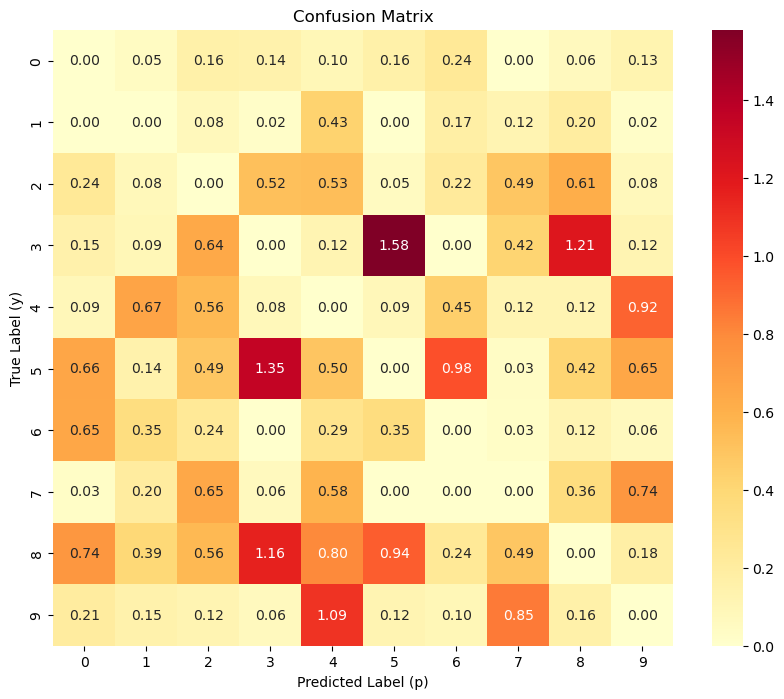

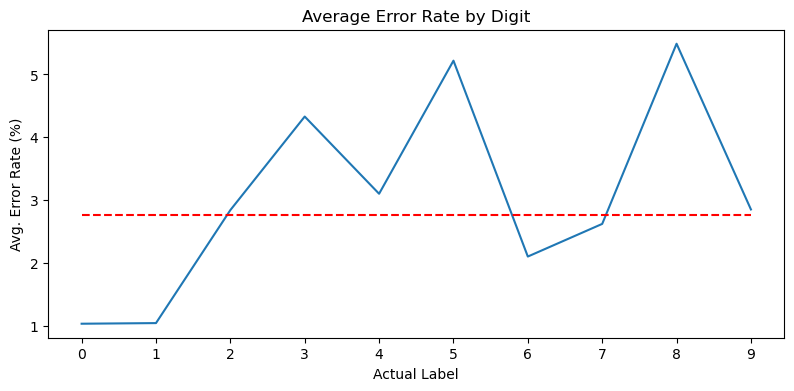

In [29]:
## PLOT CONFUSION MATRIX FOR Q4 CV-based RUN: Average Confusion Matrix over 20 runs: Mean and S.D.
draw_confusion_matrix(conf_matrix_avg)

# Average % of digits misclassified across 20 runs
avg_error_rate = np.round(torch.sum(conf_matrix_avg, dim=1).tolist(),2)

plt.figure(figsize=(9.5,4))
plt.plot(range(10),avg_error_rate)
plt.hlines(y=2.7585, xmin=0, xmax=9, color="red", linestyles="--")
plt.xticks(range(10))
plt.title("Average Error Rate by Digit")
plt.ylabel("Avg. Error Rate (%)")
plt.xlabel("Actual Label")
plt.show()

In [30]:
## Q6: Hard to Predict Samples

## HARD TO PREDICT SAMPLES
# 5 hardest to predict correctly "pixelated images"
# This would mean the predictions are under-confident or keep varying.
# OvR: lowest difference/margin b/w top 2 activations in OvR model predictions

In [31]:
## DEFINE: Hard to predict sample identification function: hardest_ovr_predict(...)

## HARDEST PREDICTIONS FOR TEST DATA FOR OvR
def hardest_ovr_predict(test_gram, alphas):
    '''
    Predicts class AND calculates difference between activations for the top-2 probability classes

    INPUTS:
    1. test_gram: (N_test,N_train) tensor; gram matrix K(x_test, x_train)
    2. alphas: (k,N_train) tensor with N_train alpha(weights) each for k classifiers

    OUTPUT:
    1. pred_test: (N_test) tensor; class predictions for N_test data points
    2. margin_activations: margin (fraction) activation between top 2 predicted classes for all test data
    '''
    ## 

    # (N_test,k) tensor: for each test data point, what are the k activations computed (each classifier gives a 'score' for binary classification)
    test_activations = test_gram @ alphas.T
    
    # Calculate Margin Activations (1st - 2nd)/abs(total sum of activations)
    abssum_activations = torch.sum(torch.absolute(test_activations), dim=1)
    sorted_activations, _ = torch.sort(test_activations, dim=1, descending=True)
    sorted_activations_top2 = sorted_activations[:,0:2]

    margin_activations = (sorted_activations_top2[:,0] - sorted_activations_top2[:,1])/abssum_activations

    # Find digit (index) with maximum activation (most probable) for each of the N_test data points
    pred_test = torch.argmax(test_activations, dim=1).float()

    return pred_test, margin_activations

In [32]:
## (MANUAL) EXPERIMENTS: run the function to identify 5 hardest to predict images based on the best model trained

top = 5
# best_param = 4

X_train_s, y_train_s, X_test_s, y_test_s = data_splitter(X_all, y_all) # (X_smoke, y_smoke)
X_train_s, y_train_s, X_test_s, y_test_s = X_train_s.float(), y_train_s.float(), X_test_s.float(), y_test_s.float()

# Experiment parameters (best polynomial OvR model)
mode = "OvR"
kernel_type = "polynomial"
max_epoch = 25

train_gram = kernel_gram_matrix(X_train_s, kernel_type, kernel_param=best_param)
test_gram = kernel_gram_matrix(X_test_s, kernel_type, kernel_param=best_param, X2=X_train_s)

alpha = ovr_train(train_gram, y_train_s, max_epoch)
train_preds, margins_train = hardest_ovr_predict(train_gram, alpha)
pred, margins_test = hardest_ovr_predict(test_gram, alpha)

worst_train, worst_train_idx = torch.sort(margins_train, dim=0, descending=False)
worst_test, worst_test_idx = torch.sort(margins_test, dim=0, descending=False)

worst_train5 = worst_train[:top]
worst_train5_idx = worst_train_idx[:top]
worst_test5 = worst_test[:top]
worst_test5_idx = worst_test_idx[:top]

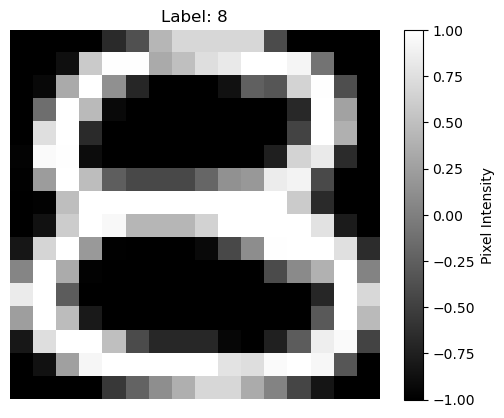

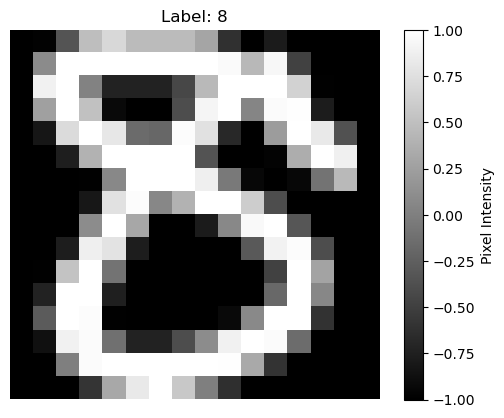

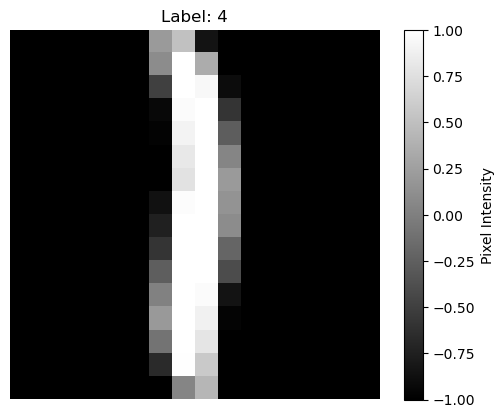

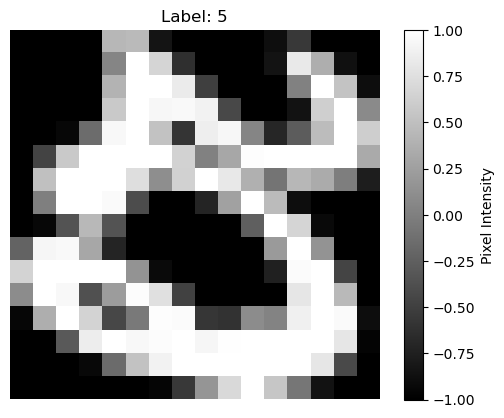

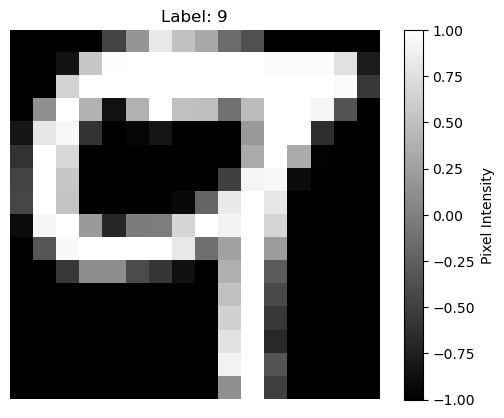

In [33]:
## PLOT IDENTIFIED 5 HARDEST TO PREDICT SAMPLES

idxs = worst_train5_idx # worst_test5_idx
# print(idxs)

for idx in idxs:
    y_idx = y_train_s[idx]
    x_idx = X_train_s[idx,:]
    image = x_idx.reshape(D,D)

    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {int(y_idx)}")
    plt.colorbar(label="Pixel Intensity")
    plt.axis("off")
    plt.show()

In [34]:
## Run Train-Test experiments (Q3) with Gaussian Kernel

In [35]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "gaussian"
binary_mode = "OvR"

# KERNEL PARAMETER RANGE TO TEST WITH
c_vals = [0.001,0.005,0.01,0.05,0.1,0.5,1.0,2.0]
max_epoch = 20

# Number of runs
runs = 20 #20

In [37]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
train_errors_list = torch.zeros((runs,num_params))
test_errors_list = torch.zeros((runs,num_params))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    train_errors, test_errors = train_test_orchestrator(X_train, y_train, X_test, y_test, binary_mode, kernel_type, kernel_param_list, max_epoch)
    train_errors_list[run] = train_errors
    test_errors_list[run] = test_errors

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) TRAIN ERROR, AND 2) TEST ERROR
print("\n")
print(f"train_errors_avg: {train_errors_avg}")
print(f"train_errors_sd: {train_errors_sd}")
print(f"test_errors_avg: {test_errors_avg}")
print(f"test_errors_sd: {test_errors_sd}")



train_errors_avg: tensor([2.3800, 0.0225, 0.0260, 0.0025, 0.0000, 0.0000, 0.0000, 0.0000])
train_errors_sd: tensor([1.1103, 0.0177, 0.0474, 0.0112, 0.0000, 0.0000, 0.0000, 0.0000])
test_errors_avg: tensor([ 5.5915,  2.8890,  2.6275,  3.8030,  5.4325,  6.6855, 10.5950, 34.7870])
test_errors_sd: tensor([1.0738, 0.4139, 0.3835, 0.5115, 0.6111, 0.4371, 0.8038, 0.7987])


In [38]:
## Run Train-Validate-Test experiments (Q4) with Gaussian Kernel

In [39]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "gaussian"
binary_mode = "OvR"

## KERNEL PARAMETER RANGE TO TEST WITH
c_vals = [0.001,0.005,0.01,0.05,0.1,0.5,1.0,2.0]
max_epoch = 25 # 20

# CV: k folds
cv_k = 5 # 5

# Number of runs
runs = 20 #20

In [40]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
best_params_list = torch.zeros((runs))
train_errors_list = torch.zeros((runs))
test_errors_list = torch.zeros((runs))
conf_matrix_list = torch.zeros((runs,10,10))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    best_param, train_error, test_error, conf_matrix = cv_orchestrator(X_train, y_train, X_test, y_test, cv_k, binary_mode, kernel_type, kernel_param_list, max_epoch)
    best_params_list[run] = best_param
    train_errors_list[run] = train_error
    test_errors_list[run] = test_error
    conf_matrix_list[run] = conf_matrix

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
best_params_avg = torch.mean(best_params_list, dim=0)
best_params_sd = torch.std(best_params_list, dim=0)

train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

conf_matrix_avg = torch.mean(conf_matrix_list, dim=0)
conf_matrix_sd = torch.std(conf_matrix_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) KERNEL HYPER PARAM., 2) TRAIN ERROR, 3) TEST ERROR, AND 4) CONFUSION MATRIX
print("\n")
print(f"best_params_avg: {best_params_avg:.2f}")
print(f"best_params_sd: {best_params_sd:.2f}")
print(f"train_errors_avg: {train_errors_avg:.4f}")
print(f"train_errors_sd: {train_errors_sd:.4f}")
print(f"test_errors_avg: {test_errors_avg:.4f}")
print(f"test_errors_sd: {test_errors_sd:.4f}\n")
# print(f"conf_matrix_avg:\n{conf_matrix_avg}")
# print(f"conf_matrix_sd:\n{conf_matrix_sd}")


Selected Best Param: 0.005


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.005


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.01


Selected Best Param: 0.005


Selected Best Param: 0.01



best_params_avg: 0.01
best_params_sd: 0.00
train_errors_avg: 0.0145
train_errors_sd: 0.0110
test_errors_avg: 2.7020
test_errors_sd: 0.3575



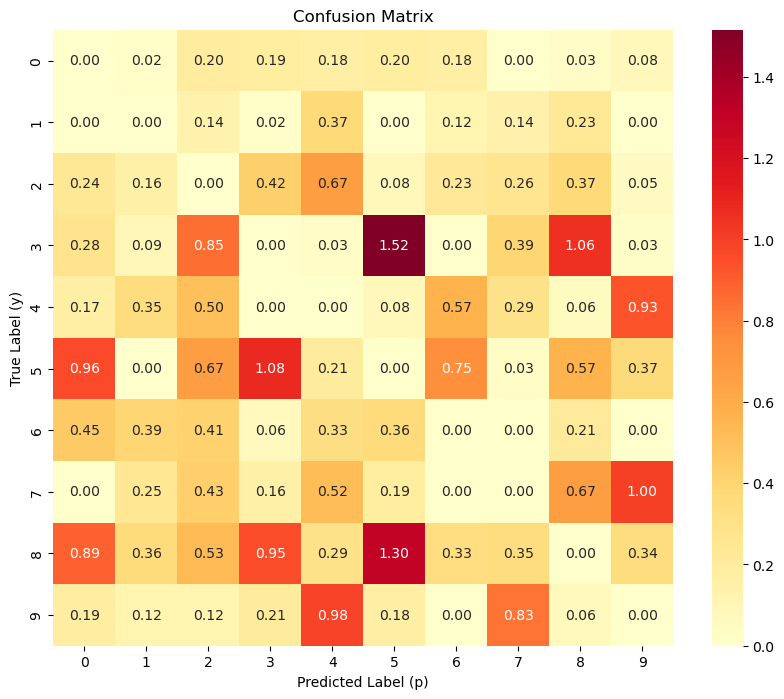

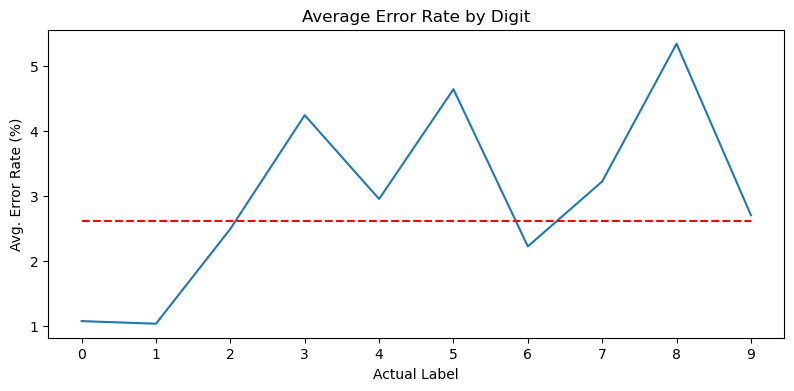

In [41]:
## PLOT CONFUSION MATRIX FOR Q7 CV-based RUN: Average Confusion Matrix over 20 runs: Mean and S.D.
draw_confusion_matrix(conf_matrix_avg)

# Average % of digits misclassified across 20 runs
avg_error_rate = np.round(torch.sum(conf_matrix_avg, dim=1).tolist(),2)

plt.figure(figsize=(9.5,4))
plt.plot(range(10),avg_error_rate)
plt.hlines(y=2.6180, xmin=0, xmax=9, color="red", linestyles="--")
plt.xticks(range(10))
plt.title("Average Error Rate by Digit")
plt.ylabel("Avg. Error Rate (%)")
plt.xlabel("Actual Label")
plt.show()

In [42]:
## Q8: One Versus One

# OvO training and prediction protocols defined above BECAUSE other functions and experiment orchestrations are designed to be AGNOSTIC of OvO/OvR <-- CHECK UNDER Q2 !!!

In [43]:
## Q8b: EXPERIMENTS - TRAIN-TEST ACROSS 20 RUNS WITH OvO

In [44]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "polynomial"
binary_mode = "OvO"

# KERNEL PARAMETER RANGE TO TEST WITH
d_vals = range(1,8)
max_epoch = 20 # (25 would work too; not much loss "saved", and only those that didn't converge would run the extra 5 epochs)

# Number of runs
runs = 20 #20

In [45]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
train_errors_list = torch.zeros((runs,num_params))
test_errors_list = torch.zeros((runs,num_params))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    train_errors, test_errors = train_test_orchestrator(X_train, y_train, X_test, y_test, binary_mode, kernel_type, kernel_param_list, max_epoch)
    train_errors_list[run] = train_errors
    test_errors_list[run] = test_errors

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) TRAIN ERROR, AND 2) TEST ERROR
print("\n")
print(f"train_errors_avg: {train_errors_avg}")
print(f"train_errors_sd: {train_errors_sd}")
print(f"test_errors_avg: {test_errors_avg}")
print(f"test_errors_sd: {test_errors_sd}")



train_errors_avg: tensor([1.7250, 0.1335, 0.0195, 0.0320, 0.0115, 0.0135, 0.0125])
train_errors_sd: tensor([0.5747, 0.3663, 0.0276, 0.0719, 0.0131, 0.0146, 0.0125])
test_errors_avg: tensor([5.8230, 3.5665, 3.2315, 3.4755, 3.2825, 3.3195, 3.5945])
test_errors_sd: tensor([0.6237, 0.5458, 0.3402, 0.3847, 0.5010, 0.3924, 0.3833])


In [46]:
## Q8c: EXPERIMENTS - TRAIN-VALIDATE-TEST ACROSS 20 RUNS WITH OvO

In [47]:
## SETUP (PARAMETERS FOR EXPERIMENTS)

# Kernel Type and Binary Classifier mode
kernel_type = "polynomial"
binary_mode = "OvO"

## KERNEL PARAMETER RANGE TO TEST WITH
d_vals = range(1,8)
max_epoch = 20

# CV: k folds
cv_k = 5

# Number of runs
runs = 20 #20


In [48]:
## RUN EXPERIMENT: Master Orchestrator script
# DON'T MODIFY ANYTHING

if kernel_type == "polynomial":
    kernel_param_list = d_vals
elif kernel_type == "gaussian":
    kernel_param_list = c_vals
else:
    print("Incorrect kernel type! Should be 'polynomial' or 'gaussian'")

# Number of params
num_params = len(kernel_param_list)

# DECLARE TENSORS TO COLLECT ERRORS FOR EACH RUN (runs (20) x num_params (7))
best_params_list = torch.zeros((runs))
train_errors_list = torch.zeros((runs))
test_errors_list = torch.zeros((runs))
conf_matrix_list = torch.zeros((runs,10,10))

for run in range(runs):
    # print(f"\n--x-- [Run = {run+1}] --x--")
    X_train, y_train, X_test, y_test = data_splitter(X_all, y_all)
    X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()
    
    best_param, train_error, test_error, conf_matrix = cv_orchestrator(X_train, y_train, X_test, y_test, cv_k, binary_mode, kernel_type, kernel_param_list, max_epoch)
    best_params_list[run] = best_param
    train_errors_list[run] = train_error
    test_errors_list[run] = test_error
    conf_matrix_list[run] = conf_matrix

## CALCULATE AND REPORT MEAN AND S.D. FOR ERRORS
best_params_avg = torch.mean(best_params_list, dim=0)
best_params_sd = torch.std(best_params_list, dim=0)

train_errors_avg = torch.mean(train_errors_list, dim=0)
train_errors_sd = torch.std(train_errors_list, dim=0)

test_errors_avg = torch.mean(test_errors_list, dim=0)
test_errors_sd = torch.std(test_errors_list, dim=0)

conf_matrix_avg = torch.mean(conf_matrix_list, dim=0)
conf_matrix_sd = torch.std(conf_matrix_list, dim=0)

## PRINT MEAN AND S.D. VALUES FOR 1) KERNEL HYPER PARAM., 2) TRAIN ERROR, 3) TEST ERROR, AND 4) CONFUSION MATRIX
print("\n")
print(f"best_params_avg: {best_params_avg:.2f}")
print(f"best_params_sd: {best_params_sd:.2f}")
print(f"train_errors_avg: {train_errors_avg:.4f}")
print(f"train_errors_sd: {train_errors_sd:.4f}")
print(f"test_errors_avg: {test_errors_avg:.4f}")
print(f"test_errors_sd: {test_errors_sd:.4f}\n")
# print(f"conf_matrix_avg:\n{conf_matrix_avg}")
# print(f"conf_matrix_sd:\n{conf_matrix_sd}")


Selected Best Param: 3


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 5


Selected Best Param: 5


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 3


Selected Best Param: 3


Selected Best Param: 5


Selected Best Param: 3


Selected Best Param: 5


Selected Best Param: 5


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 3


Selected Best Param: 4


Selected Best Param: 4


Selected Best Param: 5


Selected Best Param: 5



best_params_avg: 4.25
best_params_sd: 0.85
train_errors_avg: 0.0160
train_errors_sd: 0.0123
test_errors_avg: 3.2905
test_errors_sd: 0.3805



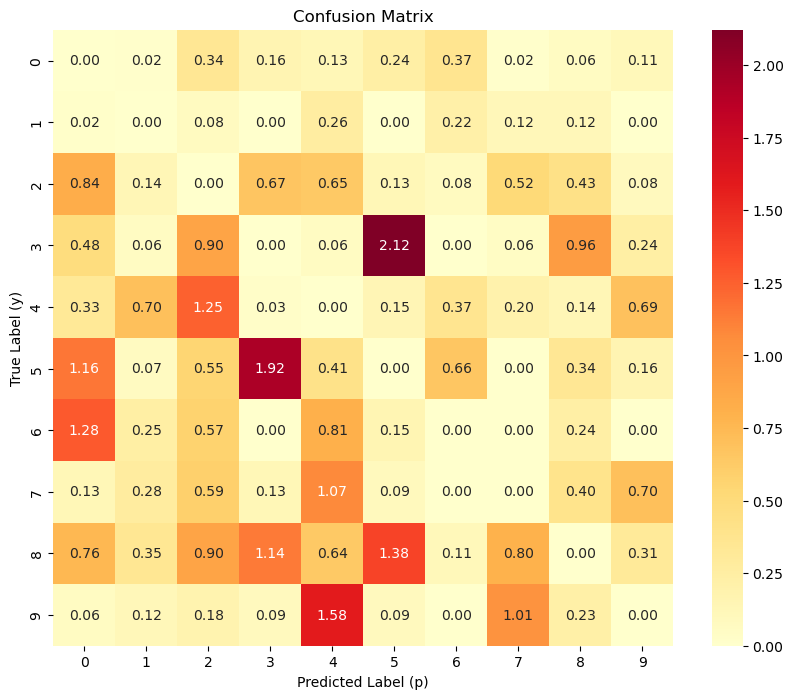

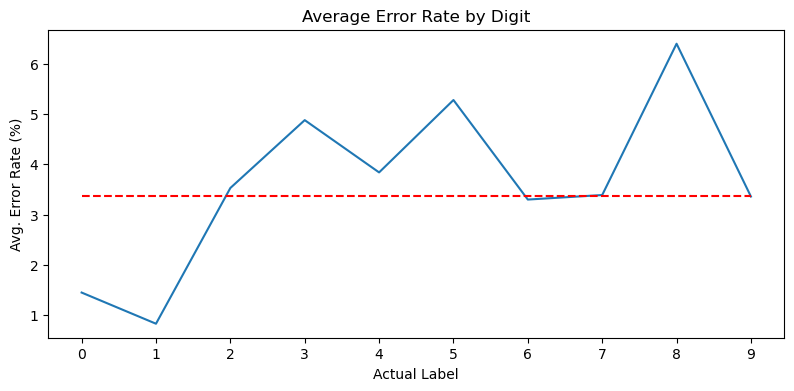

In [49]:
## PLOT CONFUSION MATRIX FOR Q7 CV-based RUN: Average Confusion Matrix over 20 runs: Mean and S.D.
draw_confusion_matrix(conf_matrix_avg)

# Average % of digits misclassified across 20 runs
avg_error_rate = np.round(torch.sum(conf_matrix_avg, dim=1).tolist(),2)

plt.figure(figsize=(9.5,4))
plt.plot(range(10),avg_error_rate)
plt.hlines(y=3.3705, xmin=0, xmax=9, color="red", linestyles="--")
plt.xticks(range(10))
plt.title("Average Error Rate by Digit")
plt.ylabel("Avg. Error Rate (%)")
plt.xlabel("Actual Label")
plt.show()